In [1]:
import re
import numpy as np
import pandas as pd
from Bio import SeqIO

In [49]:
def amino_encode_table_6(path=None):
    path = path or '6-pc'
    df = pd.read_csv(path, sep=' ', index_col=0)
    H1 = (df['H1'] - np.mean(df['H1'])) / (np.std(df['H1'], ddof=1))
    V = (df['V'] - np.mean(df['V'])) / (np.std(df['V'], ddof=1))
    P1 = (df['P1'] - np.mean(df['P1'])) / (np.std(df['P1'], ddof=1))
    Pl = (df['Pl'] - np.mean(df['Pl'])) / (np.std(df['Pl'], ddof=1))
    PKa = (df['PKa'] - np.mean(df['PKa'])) / (np.std(df['PKa'], ddof=1))
    NCI = (df['NCI'] - np.mean(df['NCI'])) / (np.std(df['NCI'], ddof=1))
    c = np.array([H1,V,P1,Pl,PKa,NCI])
    amino = ['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']
    table = {}
    for index,key in enumerate(amino):
        table[key]=c[0:6,index]
    table['X'] = [0,0,0,0,0,0]
    return table

def read_fasta(fasta_fname,length=50):
    pos = dict()
    neg = dict()
    for record in SeqIO.parse(fasta_fname, 'fasta'):
        idtag = str(record.id)
        seq = str(record.seq)[:length]
        x = idtag.split('|')[1]
        if x == '1':
            pos[idtag] = seq
        else :
            neg[idtag] = seq
        
    return pos, neg

def padding_seq(r,length=50,pad_value='X'):
    data={}
    for key, value in r.items():
        if len(r[key]) <= length:
            r[key] = [r[key]+pad_value*(length-len(r[key]))]

        data[key] = r[key]
    return data
# PC encoding

def PC6_encoding(r):
    table = amino_encode_table_6()
    data = padding_seq(r)
    dat={}
    for  key in data.keys():
        integer_encoded = []
        for amino in list(data[key][0]):
            integer_encoded.append(table[amino])
        dat[key]=integer_encoded
    return dat

In [50]:
train_pos, train_neg = read_fasta('ACVP_E_test.fa')
test_pos, test_neg = read_fasta('ACVP_M_test.fa')

In [51]:
train_pos_data = PC6_encoding(train_pos)
train_neg_data = PC6_encoding(train_neg)
test_pos_data = PC6_encoding(test_pos)
test_neg_data = PC6_encoding(test_neg)

In [52]:
# dict to np array
ACVP_array= np.array(list(train_pos_data.values()))
non_ACVP_array = np.array(list(train_neg_data.values()))
test_ACVP_array= np.array(list(test_pos_data.values()))
test_non_ACVP_array = np.array(list(test_neg_data.values()))

In [71]:
len(ACVP_array), len(non_ACVP_array), len(test_ACVP_array), len(test_non_ACVP_array)

(109, 110, 65, 2231)

In [72]:
# feature & labels (0:non_AVP, 1:AVP)
features = np.concatenate((non_ACVP_array,ACVP_array),axis=0)
labels = np.hstack((np.repeat(0, len(non_ACVP_array)),np.repeat(1, len(ACVP_array))))

In [142]:
# feature & labels
test_features = np.concatenate((test_non_ACVP_array,test_ACVP_array),axis=0)
test_labels = np.hstack((np.repeat(0, len(test_non_ACVP_array)),np.repeat(1, len(test_ACVP_array))))

In [106]:
len(test_features)

130

In [74]:
import numpy as np
import pandas as pd
from protein_encoding import PC_6, read_fasta
from model_tools import split, show_train_history, metric_array
from model import train_model
from sklearn.utils import shuffle
import tensorflow
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import LeakyReLU

In [75]:
# set gpu
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [133]:
# load best model
activation=tensorflow.keras.layers.LeakyReLU()
loaded_model = load_model('../../model/PC_6_model_best_weights.h5')

In [128]:
model.summary()

Model: "functional_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 50, 6)]           0         
                                                                 
 conv1d_12 (Conv1D)          (None, 50, 64)            3136      
                                                                 
 batch_normalization_12 (Bat  (None, 50, 64)           256       
 chNormalization)                                                
                                                                 
 dropout_12 (Dropout)        (None, 50, 64)            0         
                                                                 
 conv1d_13 (Conv1D)          (None, 50, 32)            16416     
                                                                 
 batch_normalization_13 (Bat  (None, 50, 32)           128       
 chNormalization)                                     

In [129]:
train_data, val_data, train_labels, val_labels = split(features, labels , save = False, random_state = 1)
train_data, train_labels = shuffle(train_data, train_labels, random_state=0)
val_data, val_labels = shuffle(val_data, val_labels, random_state=0)

In [138]:
import os
import tensorflow.keras
from tensorflow.keras.layers import Dense, Dropout,Add
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Input,Flatten,Masking,BatchNormalization
from tensorflow.keras.layers import LSTM,Conv1D,LeakyReLU
from tensorflow.keras import Model
from tensorflow.keras import optimizers


path = '.'
model_name = 'transfer_model'

input_ = Input(shape=(50,6))
#mask = Masking(mask_value=0.)(input_)
cnn1 = Conv1D(64 ,8,activation = 'relu', padding="same")(input_)
cnn1.trainable=False
norm1 = BatchNormalization()(cnn1)
d1 = Dropout(0.5)(norm1)
cnn2 = Conv1D(32 ,8,activation = 'relu', padding="same")(d1)
cnn2.trainable=False
norm2 = BatchNormalization()(cnn2)
d2 = Dropout(0.5)(norm2)
cnn3 = Conv1D(16 ,8,activation = 'relu', padding="same")(d2)
norm3 = BatchNormalization()(cnn3)
d3 = Dropout(0.5)(norm3)
f = Flatten()(d3)
result = Dense(1, activation = "sigmoid")(f)
model = Model(inputs=input_,outputs=result)

model.layers[1].set_weights(loaded_model.get_layer('conv1d_12').get_weights())
model.layers[4].set_weights(loaded_model.get_layer('conv1d_13').get_weights())

model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])


best_weights_filepath = path+'./%s_best_weights.h5'%model_name
saveBestModel = tensorflow.keras.callbacks.ModelCheckpoint(best_weights_filepath, 
                                                    monitor='val_loss', 
                                                    verbose=1, 
                                                    save_best_only=True, 
                                                    mode='auto')
reduce_lr = tensorflow.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                          patience=50,verbose=1)
CSVLogger = tensorflow.keras.callbacks.CSVLogger(path+"./%s_csvLogger.csv"%model_name,separator=',', append=False)
e_s = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss',
                                      min_delta=0,
                                      patience=150,
                                      verbose=0, mode='min')

history = model.fit(train_data,train_labels, validation_data=(val_data, val_labels),shuffle=True,
                epochs=2000, batch_size=100,callbacks=[saveBestModel,CSVLogger,reduce_lr,e_s])

Epoch 1/2000
1/2 [==============>...............] - ETA: 1s - loss: 1.0659 - accuracy: 0.4800
Epoch 1: val_loss improved from inf to 0.70922, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 1s 272ms/step - loss: 1.1096 - accuracy: 0.4975 - val_loss: 0.7092 - val_accuracy: 0.4091 - lr: 1.0000e-04
Epoch 2/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.9679 - accuracy: 0.5500
Epoch 2: val_loss improved from 0.70922 to 0.70681, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 114ms/step - loss: 1.0283 - accuracy: 0.5127 - val_loss: 0.7068 - val_accuracy: 0.4091 - lr: 1.0000e-04
Epoch 3/2000
1/2 [==============>...............] - ETA: 0s - loss: 1.0667 - accuracy: 0.5200
Epoch 3: val_loss improved from 0.70681 to 0.70376, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 99ms/step - loss: 1.0518 - accuracy: 0.5076 - val_loss: 0.7038 - val_accuracy: 0.4

Epoch 25/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.8029 - accuracy: 0.6100
Epoch 25: val_loss improved from 0.66038 to 0.65917, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 99ms/step - loss: 0.8211 - accuracy: 0.6041 - val_loss: 0.6592 - val_accuracy: 0.6818 - lr: 1.0000e-04
Epoch 26/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.9156 - accuracy: 0.5600
Epoch 26: val_loss improved from 0.65917 to 0.65808, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 113ms/step - loss: 0.8631 - accuracy: 0.5482 - val_loss: 0.6581 - val_accuracy: 0.6818 - lr: 1.0000e-04
Epoch 27/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.8584 - accuracy: 0.5600
Epoch 27: val_loss improved from 0.65808 to 0.65705, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 98ms/step - loss: 0.7839 - accuracy: 0.6142 - val_loss: 0.6571 - val_accu

Epoch 49/2000
1/2 [==============>...............] - ETA: 0s - loss: 1.0024 - accuracy: 0.5500
Epoch 49: val_loss improved from 0.64026 to 0.63963, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 103ms/step - loss: 0.8511 - accuracy: 0.6142 - val_loss: 0.6396 - val_accuracy: 0.6818 - lr: 1.0000e-04
Epoch 50/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.7525 - accuracy: 0.5700
Epoch 50: val_loss improved from 0.63963 to 0.63893, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 93ms/step - loss: 0.7885 - accuracy: 0.6041 - val_loss: 0.6389 - val_accuracy: 0.6818 - lr: 1.0000e-04
Epoch 51/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.7009 - accuracy: 0.7100
Epoch 51: val_loss improved from 0.63893 to 0.63817, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 100ms/step - loss: 0.7406 - accuracy: 0.6548 - val_loss: 0.6382 - val_acc

Epoch 73/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.7008 - accuracy: 0.6500
Epoch 73: val_loss improved from 0.62300 to 0.62241, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 110ms/step - loss: 0.6326 - accuracy: 0.7005 - val_loss: 0.6224 - val_accuracy: 0.6818 - lr: 1.0000e-04
Epoch 74/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.6265 - accuracy: 0.7000
Epoch 74: val_loss improved from 0.62241 to 0.62178, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 106ms/step - loss: 0.6838 - accuracy: 0.6751 - val_loss: 0.6218 - val_accuracy: 0.6818 - lr: 1.0000e-04
Epoch 75/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.8391 - accuracy: 0.6200
Epoch 75: val_loss improved from 0.62178 to 0.62114, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 106ms/step - loss: 0.7449 - accuracy: 0.6548 - val_loss: 0.6211 - val_ac

Epoch 97/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.5634 - accuracy: 0.7300
Epoch 97: val_loss improved from 0.60576 to 0.60494, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 97ms/step - loss: 0.6126 - accuracy: 0.7259 - val_loss: 0.6049 - val_accuracy: 0.6818 - lr: 1.0000e-04
Epoch 98/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.6930 - accuracy: 0.6900
Epoch 98: val_loss improved from 0.60494 to 0.60412, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 129ms/step - loss: 0.6342 - accuracy: 0.6954 - val_loss: 0.6041 - val_accuracy: 0.6818 - lr: 1.0000e-04
Epoch 99/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.6481 - accuracy: 0.6900
Epoch 99: val_loss improved from 0.60412 to 0.60326, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 100ms/step - loss: 0.6178 - accuracy: 0.7005 - val_loss: 0.6033 - val_acc

Epoch 121/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.5805 - accuracy: 0.7000
Epoch 121: val_loss improved from 0.58397 to 0.58298, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 118ms/step - loss: 0.6494 - accuracy: 0.6954 - val_loss: 0.5830 - val_accuracy: 0.7273 - lr: 1.0000e-04
Epoch 122/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.6767 - accuracy: 0.6700
Epoch 122: val_loss improved from 0.58298 to 0.58199, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 115ms/step - loss: 0.6218 - accuracy: 0.7208 - val_loss: 0.5820 - val_accuracy: 0.7273 - lr: 1.0000e-04
Epoch 123/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.5506 - accuracy: 0.7000
Epoch 123: val_loss improved from 0.58199 to 0.58106, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 113ms/step - loss: 0.6027 - accuracy: 0.6701 - val_loss: 0.5811 - 

Epoch 145/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.6002 - accuracy: 0.6900
Epoch 145: val_loss improved from 0.55811 to 0.55711, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 116ms/step - loss: 0.5508 - accuracy: 0.7259 - val_loss: 0.5571 - val_accuracy: 0.7273 - lr: 1.0000e-04
Epoch 146/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.4416 - accuracy: 0.8100
Epoch 146: val_loss improved from 0.55711 to 0.55607, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 107ms/step - loss: 0.4527 - accuracy: 0.8020 - val_loss: 0.5561 - val_accuracy: 0.7273 - lr: 1.0000e-04
Epoch 147/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.6054 - accuracy: 0.7100
Epoch 147: val_loss improved from 0.55607 to 0.55500, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 92ms/step - loss: 0.6378 - accuracy: 0.7005 - val_loss: 0.5550 - v

Epoch 169/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.5376 - accuracy: 0.7600
Epoch 169: val_loss improved from 0.52736 to 0.52614, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 96ms/step - loss: 0.4991 - accuracy: 0.7919 - val_loss: 0.5261 - val_accuracy: 0.7273 - lr: 1.0000e-04
Epoch 170/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.5193 - accuracy: 0.7800
Epoch 170: val_loss improved from 0.52614 to 0.52487, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 108ms/step - loss: 0.5045 - accuracy: 0.7919 - val_loss: 0.5249 - val_accuracy: 0.7273 - lr: 1.0000e-04
Epoch 171/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.5726 - accuracy: 0.7900
Epoch 171: val_loss improved from 0.52487 to 0.52363, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 94ms/step - loss: 0.5552 - accuracy: 0.7868 - val_loss: 0.5236 - va

Epoch 193/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.4433 - accuracy: 0.7600
Epoch 193: val_loss improved from 0.49748 to 0.49637, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 117ms/step - loss: 0.4307 - accuracy: 0.7665 - val_loss: 0.4964 - val_accuracy: 0.7273 - lr: 1.0000e-04
Epoch 194/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.5342 - accuracy: 0.7000
Epoch 194: val_loss improved from 0.49637 to 0.49528, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 107ms/step - loss: 0.4417 - accuracy: 0.7665 - val_loss: 0.4953 - val_accuracy: 0.7273 - lr: 1.0000e-04
Epoch 195/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.4513 - accuracy: 0.8200
Epoch 195: val_loss improved from 0.49528 to 0.49425, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 113ms/step - loss: 0.4867 - accuracy: 0.7766 - val_loss: 0.4943 - 

Epoch 217/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.3815 - accuracy: 0.8300
Epoch 217: val_loss improved from 0.47204 to 0.47087, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 106ms/step - loss: 0.4058 - accuracy: 0.8071 - val_loss: 0.4709 - val_accuracy: 0.7273 - lr: 1.0000e-04
Epoch 218/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.4176 - accuracy: 0.7800
Epoch 218: val_loss improved from 0.47087 to 0.46960, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 108ms/step - loss: 0.4264 - accuracy: 0.7817 - val_loss: 0.4696 - val_accuracy: 0.7273 - lr: 1.0000e-04
Epoch 219/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.3512 - accuracy: 0.8700
Epoch 219: val_loss improved from 0.46960 to 0.46859, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 111ms/step - loss: 0.4079 - accuracy: 0.8376 - val_loss: 0.4686 - 

Epoch 241/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.3265 - accuracy: 0.8400
Epoch 241: val_loss improved from 0.44945 to 0.44845, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 91ms/step - loss: 0.3659 - accuracy: 0.8325 - val_loss: 0.4485 - val_accuracy: 0.7273 - lr: 1.0000e-04
Epoch 242/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.3993 - accuracy: 0.8400
Epoch 242: val_loss improved from 0.44845 to 0.44735, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 111ms/step - loss: 0.4082 - accuracy: 0.8071 - val_loss: 0.4474 - val_accuracy: 0.7273 - lr: 1.0000e-04
Epoch 243/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.3603 - accuracy: 0.8400
Epoch 243: val_loss improved from 0.44735 to 0.44644, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 97ms/step - loss: 0.3773 - accuracy: 0.8325 - val_loss: 0.4464 - va

Epoch 265/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.2987 - accuracy: 0.8700
Epoch 265: val_loss improved from 0.42929 to 0.42858, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 118ms/step - loss: 0.3500 - accuracy: 0.8477 - val_loss: 0.4286 - val_accuracy: 0.7273 - lr: 1.0000e-04
Epoch 266/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.3864 - accuracy: 0.7900
Epoch 266: val_loss improved from 0.42858 to 0.42790, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 98ms/step - loss: 0.3962 - accuracy: 0.8122 - val_loss: 0.4279 - val_accuracy: 0.7273 - lr: 1.0000e-04
Epoch 267/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.3346 - accuracy: 0.8400
Epoch 267: val_loss improved from 0.42790 to 0.42721, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 118ms/step - loss: 0.3342 - accuracy: 0.8426 - val_loss: 0.4272 - v

Epoch 289/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.3436 - accuracy: 0.8500
Epoch 289: val_loss improved from 0.41127 to 0.41054, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 101ms/step - loss: 0.3509 - accuracy: 0.8274 - val_loss: 0.4105 - val_accuracy: 0.7727 - lr: 1.0000e-04
Epoch 290/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.3626 - accuracy: 0.8400
Epoch 290: val_loss improved from 0.41054 to 0.40991, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 95ms/step - loss: 0.3563 - accuracy: 0.8325 - val_loss: 0.4099 - val_accuracy: 0.7727 - lr: 1.0000e-04
Epoch 291/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.2774 - accuracy: 0.8900
Epoch 291: val_loss improved from 0.40991 to 0.40936, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 117ms/step - loss: 0.3290 - accuracy: 0.8426 - val_loss: 0.4094 - v

Epoch 313/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.2882 - accuracy: 0.9100
Epoch 313: val_loss improved from 0.39517 to 0.39472, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 113ms/step - loss: 0.3184 - accuracy: 0.8629 - val_loss: 0.3947 - val_accuracy: 0.7727 - lr: 1.0000e-04
Epoch 314/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.3024 - accuracy: 0.8600
Epoch 314: val_loss improved from 0.39472 to 0.39428, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 105ms/step - loss: 0.2901 - accuracy: 0.8629 - val_loss: 0.3943 - val_accuracy: 0.7727 - lr: 1.0000e-04
Epoch 315/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.3134 - accuracy: 0.8500
Epoch 315: val_loss improved from 0.39428 to 0.39404, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 100ms/step - loss: 0.3266 - accuracy: 0.8477 - val_loss: 0.3940 - 

2/2 [==============================] - 0s 93ms/step - loss: 0.3385 - accuracy: 0.8579 - val_loss: 0.3842 - val_accuracy: 0.7727 - lr: 1.0000e-04
Epoch 338/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.3399 - accuracy: 0.8200
Epoch 338: val_loss improved from 0.38418 to 0.38349, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 99ms/step - loss: 0.3563 - accuracy: 0.8223 - val_loss: 0.3835 - val_accuracy: 0.7727 - lr: 1.0000e-04
Epoch 339/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.3125 - accuracy: 0.8800
Epoch 339: val_loss improved from 0.38349 to 0.38290, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 103ms/step - loss: 0.2671 - accuracy: 0.8883 - val_loss: 0.3829 - val_accuracy: 0.7727 - lr: 1.0000e-04
Epoch 340/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.2270 - accuracy: 0.9300
Epoch 340: val_loss improved from 0.38290 to 0.38230, saving model t

2/2 [==============================] - 0s 114ms/step - loss: 0.2696 - accuracy: 0.8883 - val_loss: 0.3684 - val_accuracy: 0.7727 - lr: 1.0000e-04
Epoch 362/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.2617 - accuracy: 0.9100
Epoch 362: val_loss improved from 0.36836 to 0.36771, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 96ms/step - loss: 0.2645 - accuracy: 0.8883 - val_loss: 0.3677 - val_accuracy: 0.7727 - lr: 1.0000e-04
Epoch 363/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.3231 - accuracy: 0.8400
Epoch 363: val_loss improved from 0.36771 to 0.36697, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 121ms/step - loss: 0.2838 - accuracy: 0.8731 - val_loss: 0.3670 - val_accuracy: 0.7727 - lr: 1.0000e-04
Epoch 364/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.2609 - accuracy: 0.8900
Epoch 364: val_loss improved from 0.36697 to 0.36637, saving model 

Epoch 412/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.1971 - accuracy: 0.9100
Epoch 412: val_loss improved from 0.35422 to 0.35359, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 113ms/step - loss: 0.2602 - accuracy: 0.8934 - val_loss: 0.3536 - val_accuracy: 0.7727 - lr: 1.0000e-04
Epoch 413/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.2519 - accuracy: 0.9300
Epoch 413: val_loss improved from 0.35359 to 0.35331, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 114ms/step - loss: 0.2884 - accuracy: 0.8985 - val_loss: 0.3533 - val_accuracy: 0.7727 - lr: 1.0000e-04
Epoch 414/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.2528 - accuracy: 0.9100
Epoch 414: val_loss improved from 0.35331 to 0.35289, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 120ms/step - loss: 0.2135 - accuracy: 0.9340 - val_loss: 0.3529 - 

Epoch 436/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.1932 - accuracy: 0.9300
Epoch 436: val_loss improved from 0.33961 to 0.33897, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 96ms/step - loss: 0.2509 - accuracy: 0.8883 - val_loss: 0.3390 - val_accuracy: 0.7727 - lr: 1.0000e-04
Epoch 437/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.1817 - accuracy: 0.9300
Epoch 437: val_loss improved from 0.33897 to 0.33849, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 99ms/step - loss: 0.1992 - accuracy: 0.9239 - val_loss: 0.3385 - val_accuracy: 0.7727 - lr: 1.0000e-04
Epoch 438/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.2510 - accuracy: 0.9100
Epoch 438: val_loss improved from 0.33849 to 0.33805, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 107ms/step - loss: 0.2569 - accuracy: 0.8985 - val_loss: 0.3381 - va

Epoch 461/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.2774 - accuracy: 0.8900
Epoch 461: val_loss improved from 0.32976 to 0.32956, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 117ms/step - loss: 0.2563 - accuracy: 0.8985 - val_loss: 0.3296 - val_accuracy: 0.7727 - lr: 1.0000e-04
Epoch 462/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.1574 - accuracy: 0.9500
Epoch 462: val_loss did not improve from 0.32956
2/2 [==============================] - 0s 59ms/step - loss: 0.2161 - accuracy: 0.9036 - val_loss: 0.3296 - val_accuracy: 0.7727 - lr: 1.0000e-04
Epoch 463/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.1687 - accuracy: 0.9600
Epoch 463: val_loss did not improve from 0.32956
2/2 [==============================] - 0s 71ms/step - loss: 0.2049 - accuracy: 0.9340 - val_loss: 0.3296 - val_accuracy: 0.7727 - lr: 1.0000e-04
Epoch 464/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.22

2/2 [==============================] - 0s 122ms/step - loss: 0.2313 - accuracy: 0.8985 - val_loss: 0.3249 - val_accuracy: 0.7727 - lr: 1.0000e-04
Epoch 487/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.2311 - accuracy: 0.9400
Epoch 487: val_loss improved from 0.32495 to 0.32465, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 117ms/step - loss: 0.2163 - accuracy: 0.9340 - val_loss: 0.3246 - val_accuracy: 0.7727 - lr: 1.0000e-04
Epoch 488/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.1723 - accuracy: 0.9700
Epoch 488: val_loss improved from 0.32465 to 0.32442, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 120ms/step - loss: 0.1828 - accuracy: 0.9391 - val_loss: 0.3244 - val_accuracy: 0.7727 - lr: 1.0000e-04
Epoch 489/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.1815 - accuracy: 0.9400
Epoch 489: val_loss improved from 0.32442 to 0.32411, saving model

Epoch 536/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.1845 - accuracy: 0.9200
Epoch 536: val_loss did not improve from 0.31323
2/2 [==============================] - 0s 65ms/step - loss: 0.1815 - accuracy: 0.9137 - val_loss: 0.3151 - val_accuracy: 0.7727 - lr: 1.0000e-04
Epoch 537/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.1479 - accuracy: 0.9500
Epoch 537: val_loss did not improve from 0.31323
2/2 [==============================] - 0s 67ms/step - loss: 0.1878 - accuracy: 0.9086 - val_loss: 0.3153 - val_accuracy: 0.7727 - lr: 1.0000e-04
Epoch 538/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.2073 - accuracy: 0.9200
Epoch 538: val_loss did not improve from 0.31323
2/2 [==============================] - 0s 75ms/step - loss: 0.1854 - accuracy: 0.9239 - val_loss: 0.3151 - val_accuracy: 0.7727 - lr: 1.0000e-04
Epoch 539/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.1924 - accuracy: 0.9400
Epoch 539: val_loss did not improv

2/2 [==============================] - 0s 68ms/step - loss: 0.1803 - accuracy: 0.9340 - val_loss: 0.3075 - val_accuracy: 0.7727 - lr: 1.0000e-04
Epoch 562/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.1422 - accuracy: 0.9600
Epoch 562: val_loss did not improve from 0.30731
2/2 [==============================] - 0s 70ms/step - loss: 0.1681 - accuracy: 0.9442 - val_loss: 0.3073 - val_accuracy: 0.7727 - lr: 1.0000e-04
Epoch 563/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.1676 - accuracy: 0.9300
Epoch 563: val_loss did not improve from 0.30731
2/2 [==============================] - 0s 66ms/step - loss: 0.1797 - accuracy: 0.9289 - val_loss: 0.3074 - val_accuracy: 0.7727 - lr: 1.0000e-04
Epoch 564/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.1561 - accuracy: 0.9200
Epoch 564: val_loss did not improve from 0.30731
2/2 [==============================] - 0s 68ms/step - loss: 0.1541 - accuracy: 0.9391 - val_loss: 0.3074 - val_accuracy: 0.7727 - 

2/2 [==============================] - 0s 116ms/step - loss: 0.1356 - accuracy: 0.9645 - val_loss: 0.2993 - val_accuracy: 0.7727 - lr: 1.0000e-04
Epoch 587/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.1556 - accuracy: 0.9400
Epoch 587: val_loss improved from 0.29935 to 0.29913, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 124ms/step - loss: 0.1580 - accuracy: 0.9442 - val_loss: 0.2991 - val_accuracy: 0.7727 - lr: 1.0000e-04
Epoch 588/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.1950 - accuracy: 0.9200
Epoch 588: val_loss improved from 0.29913 to 0.29909, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 179ms/step - loss: 0.1911 - accuracy: 0.9188 - val_loss: 0.2991 - val_accuracy: 0.7727 - lr: 1.0000e-04
Epoch 589/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.1312 - accuracy: 0.9500
Epoch 589: val_loss did not improve from 0.29909
2/2 [============

2/2 [==============================] - 0s 113ms/step - loss: 0.1418 - accuracy: 0.9492 - val_loss: 0.2931 - val_accuracy: 0.8182 - lr: 1.0000e-04
Epoch 611/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.1372 - accuracy: 0.9600
Epoch 611: val_loss improved from 0.29310 to 0.29276, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 97ms/step - loss: 0.1126 - accuracy: 0.9746 - val_loss: 0.2928 - val_accuracy: 0.8182 - lr: 1.0000e-04
Epoch 612/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.1625 - accuracy: 0.9100
Epoch 612: val_loss improved from 0.29276 to 0.29238, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 99ms/step - loss: 0.1607 - accuracy: 0.9239 - val_loss: 0.2924 - val_accuracy: 0.8182 - lr: 1.0000e-04
Epoch 613/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.1546 - accuracy: 0.9400
Epoch 613: val_loss improved from 0.29238 to 0.29200, saving model t

2/2 [==============================] - 0s 101ms/step - loss: 0.1458 - accuracy: 0.9442 - val_loss: 0.2882 - val_accuracy: 0.8182 - lr: 1.0000e-04
Epoch 637/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.1347 - accuracy: 0.9600
Epoch 637: val_loss improved from 0.28825 to 0.28759, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 115ms/step - loss: 0.1359 - accuracy: 0.9543 - val_loss: 0.2876 - val_accuracy: 0.8182 - lr: 1.0000e-04
Epoch 638/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.1299 - accuracy: 0.9500
Epoch 638: val_loss improved from 0.28759 to 0.28665, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 98ms/step - loss: 0.1421 - accuracy: 0.9543 - val_loss: 0.2866 - val_accuracy: 0.8182 - lr: 1.0000e-04
Epoch 639/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.1557 - accuracy: 0.9300
Epoch 639: val_loss improved from 0.28665 to 0.28574, saving model 

Epoch 686/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.1333 - accuracy: 0.9500
Epoch 686: val_loss did not improve from 0.27137
2/2 [==============================] - 0s 64ms/step - loss: 0.1342 - accuracy: 0.9543 - val_loss: 0.2720 - val_accuracy: 0.8182 - lr: 1.0000e-04
Epoch 687/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.1340 - accuracy: 0.9600
Epoch 687: val_loss did not improve from 0.27137
2/2 [==============================] - 0s 65ms/step - loss: 0.1181 - accuracy: 0.9645 - val_loss: 0.2714 - val_accuracy: 0.8182 - lr: 1.0000e-04
Epoch 688/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.1302 - accuracy: 0.9300
Epoch 688: val_loss improved from 0.27137 to 0.27081, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 111ms/step - loss: 0.1250 - accuracy: 0.9442 - val_loss: 0.2708 - val_accuracy: 0.8182 - lr: 1.0000e-04
Epoch 689/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.09

2/2 [==============================] - 0s 101ms/step - loss: 0.1248 - accuracy: 0.9492 - val_loss: 0.2674 - val_accuracy: 0.8182 - lr: 1.0000e-04
Epoch 713/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.1129 - accuracy: 0.9600
Epoch 713: val_loss improved from 0.26739 to 0.26704, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 100ms/step - loss: 0.0980 - accuracy: 0.9695 - val_loss: 0.2670 - val_accuracy: 0.8182 - lr: 1.0000e-04
Epoch 714/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.0775 - accuracy: 0.9700
Epoch 714: val_loss improved from 0.26704 to 0.26674, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 110ms/step - loss: 0.1220 - accuracy: 0.9492 - val_loss: 0.2667 - val_accuracy: 0.8182 - lr: 1.0000e-04
Epoch 715/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.1054 - accuracy: 0.9700
Epoch 715: val_loss improved from 0.26674 to 0.26625, saving model

Epoch 738/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.0779 - accuracy: 0.9700
Epoch 738: val_loss improved from 0.26321 to 0.26290, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 103ms/step - loss: 0.0855 - accuracy: 0.9746 - val_loss: 0.2629 - val_accuracy: 0.8182 - lr: 1.0000e-04
Epoch 739/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.1436 - accuracy: 0.9500
Epoch 739: val_loss improved from 0.26290 to 0.26232, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 117ms/step - loss: 0.1120 - accuracy: 0.9645 - val_loss: 0.2623 - val_accuracy: 0.8182 - lr: 1.0000e-04
Epoch 740/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.1492 - accuracy: 0.9200
Epoch 740: val_loss improved from 0.26232 to 0.26170, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 114ms/step - loss: 0.1262 - accuracy: 0.9442 - val_loss: 0.2617 - 

Epoch 763/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.0784 - accuracy: 0.9700
Epoch 763: val_loss did not improve from 0.25629
2/2 [==============================] - 0s 63ms/step - loss: 0.1033 - accuracy: 0.9594 - val_loss: 0.2575 - val_accuracy: 0.8182 - lr: 1.0000e-04
Epoch 764/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.1274 - accuracy: 0.9500
Epoch 764: val_loss did not improve from 0.25629
2/2 [==============================] - 0s 69ms/step - loss: 0.1206 - accuracy: 0.9543 - val_loss: 0.2577 - val_accuracy: 0.8182 - lr: 1.0000e-04
Epoch 765/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.1114 - accuracy: 0.9500
Epoch 765: val_loss did not improve from 0.25629
2/2 [==============================] - 0s 63ms/step - loss: 0.1149 - accuracy: 0.9543 - val_loss: 0.2580 - val_accuracy: 0.8182 - lr: 1.0000e-04
Epoch 766/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.0827 - accuracy: 0.9700
Epoch 766: val_loss did not improv

Epoch 814/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.0865 - accuracy: 0.9700
Epoch 814: val_loss improved from 0.24425 to 0.24362, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 116ms/step - loss: 0.0778 - accuracy: 0.9797 - val_loss: 0.2436 - val_accuracy: 0.8636 - lr: 1.0000e-04
Epoch 815/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.0731 - accuracy: 0.9700
Epoch 815: val_loss improved from 0.24362 to 0.24307, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 114ms/step - loss: 0.0828 - accuracy: 0.9695 - val_loss: 0.2431 - val_accuracy: 0.8636 - lr: 1.0000e-04
Epoch 816/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.0829 - accuracy: 0.9800
Epoch 816: val_loss improved from 0.24307 to 0.24270, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 115ms/step - loss: 0.1042 - accuracy: 0.9746 - val_loss: 0.2427 - 

Epoch 841/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.1037 - accuracy: 0.9500
Epoch 841: val_loss did not improve from 0.24173
2/2 [==============================] - 0s 64ms/step - loss: 0.1039 - accuracy: 0.9645 - val_loss: 0.2434 - val_accuracy: 0.8636 - lr: 1.0000e-04
Epoch 842/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.1339 - accuracy: 0.9300
Epoch 842: val_loss did not improve from 0.24173
2/2 [==============================] - 0s 71ms/step - loss: 0.1023 - accuracy: 0.9492 - val_loss: 0.2428 - val_accuracy: 0.8636 - lr: 1.0000e-04
Epoch 843/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.0532 - accuracy: 0.9900
Epoch 843: val_loss did not improve from 0.24173
2/2 [==============================] - 0s 64ms/step - loss: 0.0660 - accuracy: 0.9797 - val_loss: 0.2424 - val_accuracy: 0.8636 - lr: 1.0000e-04
Epoch 844/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.0743 - accuracy: 0.9800
Epoch 844: val_loss did not improv

Epoch 866/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.0902 - accuracy: 0.9600
Epoch 866: val_loss improved from 0.23234 to 0.23198, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 105ms/step - loss: 0.0860 - accuracy: 0.9645 - val_loss: 0.2320 - val_accuracy: 0.8636 - lr: 1.0000e-04
Epoch 867/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.0347 - accuracy: 1.0000
Epoch 867: val_loss improved from 0.23198 to 0.23184, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 94ms/step - loss: 0.0566 - accuracy: 0.9898 - val_loss: 0.2318 - val_accuracy: 0.8636 - lr: 1.0000e-04
Epoch 868/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.1488 - accuracy: 0.9400
Epoch 868: val_loss did not improve from 0.23184
2/2 [==============================] - 0s 49ms/step - loss: 0.1104 - accuracy: 0.9543 - val_loss: 0.2321 - val_accuracy: 0.8636 - lr: 1.0000e-04
Epoch 869/2000
1/2 

Epoch 893/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.0775 - accuracy: 0.9900
Epoch 893: val_loss improved from 0.23096 to 0.23087, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 99ms/step - loss: 0.0610 - accuracy: 0.9949 - val_loss: 0.2309 - val_accuracy: 0.9091 - lr: 1.0000e-04
Epoch 894/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.0476 - accuracy: 1.0000
Epoch 894: val_loss improved from 0.23087 to 0.23062, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 101ms/step - loss: 0.0757 - accuracy: 0.9797 - val_loss: 0.2306 - val_accuracy: 0.9091 - lr: 1.0000e-04
Epoch 895/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.1075 - accuracy: 0.9500
Epoch 895: val_loss improved from 0.23062 to 0.22999, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 97ms/step - loss: 0.1187 - accuracy: 0.9492 - val_loss: 0.2300 - va

Epoch 918/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.0577 - accuracy: 0.9900
Epoch 918: val_loss did not improve from 0.22515
2/2 [==============================] - 0s 67ms/step - loss: 0.0831 - accuracy: 0.9746 - val_loss: 0.2252 - val_accuracy: 0.9091 - lr: 1.0000e-04
Epoch 919/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.0428 - accuracy: 0.9900
Epoch 919: val_loss improved from 0.22515 to 0.22502, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 107ms/step - loss: 0.0668 - accuracy: 0.9898 - val_loss: 0.2250 - val_accuracy: 0.9091 - lr: 1.0000e-04
Epoch 920/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.0537 - accuracy: 0.9900
Epoch 920: val_loss improved from 0.22502 to 0.22470, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 99ms/step - loss: 0.0687 - accuracy: 0.9797 - val_loss: 0.2247 - val_accuracy: 0.9091 - lr: 1.0000e-04
Epoch 921/2000
1/2 

2/2 [==============================] - 0s 99ms/step - loss: 0.0477 - accuracy: 0.9848 - val_loss: 0.2169 - val_accuracy: 0.9091 - lr: 1.0000e-04
Epoch 970/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.0826 - accuracy: 0.9800
Epoch 970: val_loss did not improve from 0.21688
2/2 [==============================] - 0s 63ms/step - loss: 0.0831 - accuracy: 0.9746 - val_loss: 0.2171 - val_accuracy: 0.9091 - lr: 1.0000e-04
Epoch 971/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.1046 - accuracy: 0.9600
Epoch 971: val_loss did not improve from 0.21688
2/2 [==============================] - 0s 68ms/step - loss: 0.0871 - accuracy: 0.9695 - val_loss: 0.2178 - val_accuracy: 0.9091 - lr: 1.0000e-04
Epoch 972/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.0724 - accuracy: 0.9700
Epoch 972: val_loss did not improve from 0.21688
2/2 [==============================] - 0s 68ms/step - loss: 0.0687 - accuracy: 0.9695 - val_loss: 0.2185 - val_accuracy: 0.9091 - 

Epoch 998/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.0396 - accuracy: 0.9900
Epoch 998: val_loss did not improve from 0.21688
2/2 [==============================] - 0s 67ms/step - loss: 0.0342 - accuracy: 0.9949 - val_loss: 0.2178 - val_accuracy: 0.9091 - lr: 1.0000e-04
Epoch 999/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.0680 - accuracy: 0.9700
Epoch 999: val_loss did not improve from 0.21688
2/2 [==============================] - 0s 66ms/step - loss: 0.0652 - accuracy: 0.9746 - val_loss: 0.2179 - val_accuracy: 0.9091 - lr: 1.0000e-04
Epoch 1000/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.0710 - accuracy: 0.9800
Epoch 1000: val_loss did not improve from 0.21688
2/2 [==============================] - 0s 67ms/step - loss: 0.0659 - accuracy: 0.9746 - val_loss: 0.2179 - val_accuracy: 0.9091 - lr: 1.0000e-04
Epoch 1001/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.0865 - accuracy: 0.9800
Epoch 1001: val_loss did not im

2/2 [==============================] - 0s 125ms/step - loss: 0.0663 - accuracy: 0.9898 - val_loss: 0.2159 - val_accuracy: 0.9091 - lr: 5.0000e-05
Epoch 1026/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.0465 - accuracy: 0.9900
Epoch 1026: val_loss improved from 0.21587 to 0.21525, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 135ms/step - loss: 0.0564 - accuracy: 0.9848 - val_loss: 0.2152 - val_accuracy: 0.9091 - lr: 5.0000e-05
Epoch 1027/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.0706 - accuracy: 0.9800
Epoch 1027: val_loss improved from 0.21525 to 0.21460, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 104ms/step - loss: 0.0671 - accuracy: 0.9746 - val_loss: 0.2146 - val_accuracy: 0.9091 - lr: 5.0000e-05
Epoch 1028/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.0415 - accuracy: 1.0000
Epoch 1028: val_loss improved from 0.21460 to 0.21406, saving

2/2 [==============================] - 0s 126ms/step - loss: 0.0442 - accuracy: 0.9797 - val_loss: 0.2100 - val_accuracy: 0.9091 - lr: 5.0000e-05
Epoch 1077/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.0465 - accuracy: 0.9900
Epoch 1077: val_loss improved from 0.21001 to 0.20963, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 90ms/step - loss: 0.0478 - accuracy: 0.9848 - val_loss: 0.2096 - val_accuracy: 0.9091 - lr: 5.0000e-05
Epoch 1078/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.0511 - accuracy: 0.9700
Epoch 1078: val_loss improved from 0.20963 to 0.20932, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 94ms/step - loss: 0.0502 - accuracy: 0.9746 - val_loss: 0.2093 - val_accuracy: 0.9091 - lr: 5.0000e-05
Epoch 1079/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.0822 - accuracy: 0.9600
Epoch 1079: val_loss improved from 0.20932 to 0.20887, saving m

Epoch 1102/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.0343 - accuracy: 0.9900
Epoch 1102: val_loss improved from 0.20571 to 0.20545, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 104ms/step - loss: 0.0448 - accuracy: 0.9848 - val_loss: 0.2054 - val_accuracy: 0.9091 - lr: 5.0000e-05
Epoch 1103/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.0350 - accuracy: 0.9900
Epoch 1103: val_loss improved from 0.20545 to 0.20524, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 99ms/step - loss: 0.0458 - accuracy: 0.9848 - val_loss: 0.2052 - val_accuracy: 0.9091 - lr: 5.0000e-05
Epoch 1104/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.0401 - accuracy: 1.0000
Epoch 1104: val_loss improved from 0.20524 to 0.20492, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 262ms/step - loss: 0.0338 - accuracy: 0.9949 - val_loss: 0.20

2/2 [==============================] - 0s 64ms/step - loss: 0.0477 - accuracy: 0.9898 - val_loss: 0.2042 - val_accuracy: 0.9091 - lr: 5.0000e-05
Epoch 1127/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.0545 - accuracy: 0.9800
Epoch 1127: val_loss did not improve from 0.20181
2/2 [==============================] - 0s 70ms/step - loss: 0.0530 - accuracy: 0.9848 - val_loss: 0.2043 - val_accuracy: 0.9091 - lr: 5.0000e-05
Epoch 1128/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.0403 - accuracy: 0.9900
Epoch 1128: val_loss did not improve from 0.20181
2/2 [==============================] - 0s 70ms/step - loss: 0.0463 - accuracy: 0.9898 - val_loss: 0.2044 - val_accuracy: 0.9091 - lr: 5.0000e-05
Epoch 1129/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.0505 - accuracy: 0.9900
Epoch 1129: val_loss did not improve from 0.20181
2/2 [==============================] - 0s 79ms/step - loss: 0.0582 - accuracy: 0.9797 - val_loss: 0.2044 - val_accuracy: 0.9

Epoch 1154/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.0788 - accuracy: 0.9800
Epoch 1154: val_loss did not improve from 0.20049
2/2 [==============================] - 0s 63ms/step - loss: 0.0640 - accuracy: 0.9797 - val_loss: 0.2042 - val_accuracy: 0.9091 - lr: 5.0000e-05
Epoch 1155/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.0454 - accuracy: 0.9900
Epoch 1155: val_loss did not improve from 0.20049
2/2 [==============================] - 0s 63ms/step - loss: 0.0290 - accuracy: 0.9949 - val_loss: 0.2044 - val_accuracy: 0.9091 - lr: 5.0000e-05
Epoch 1156/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.0225 - accuracy: 1.0000
Epoch 1156: val_loss did not improve from 0.20049
2/2 [==============================] - 0s 65ms/step - loss: 0.0533 - accuracy: 0.9898 - val_loss: 0.2043 - val_accuracy: 0.9091 - lr: 5.0000e-05
Epoch 1157/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.0406 - accuracy: 0.9900
Epoch 1157: val_loss did no

Epoch 1181/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.0258 - accuracy: 1.0000
Epoch 1181: val_loss improved from 0.19795 to 0.19763, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 116ms/step - loss: 0.0461 - accuracy: 0.9898 - val_loss: 0.1976 - val_accuracy: 0.9091 - lr: 5.0000e-05
Epoch 1182/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.0287 - accuracy: 1.0000
Epoch 1182: val_loss improved from 0.19763 to 0.19720, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 116ms/step - loss: 0.0362 - accuracy: 1.0000 - val_loss: 0.1972 - val_accuracy: 0.9091 - lr: 5.0000e-05
Epoch 1183/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.0544 - accuracy: 0.9900
Epoch 1183: val_loss improved from 0.19720 to 0.19702, saving model to ../transfer_model_best_weights.h5
2/2 [==============================] - 0s 100ms/step - loss: 0.0472 - accuracy: 0.9949 - val_loss: 0.1

Epoch 1206/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.0362 - accuracy: 0.9900
Epoch 1206: val_loss did not improve from 0.19520
2/2 [==============================] - 0s 71ms/step - loss: 0.0429 - accuracy: 0.9898 - val_loss: 0.1961 - val_accuracy: 0.9091 - lr: 5.0000e-05
Epoch 1207/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.0657 - accuracy: 0.9700
Epoch 1207: val_loss did not improve from 0.19520
2/2 [==============================] - 0s 66ms/step - loss: 0.0482 - accuracy: 0.9848 - val_loss: 0.1966 - val_accuracy: 0.9091 - lr: 5.0000e-05
Epoch 1208/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.0475 - accuracy: 0.9900
Epoch 1208: val_loss did not improve from 0.19520
2/2 [==============================] - 0s 66ms/step - loss: 0.0432 - accuracy: 0.9898 - val_loss: 0.1968 - val_accuracy: 0.9091 - lr: 5.0000e-05
Epoch 1209/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.0600 - accuracy: 0.9900
Epoch 1209: val_loss did no

Epoch 1262/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.0362 - accuracy: 0.9900
Epoch 1262: val_loss did not improve from 0.19520
2/2 [==============================] - 0s 66ms/step - loss: 0.0368 - accuracy: 0.9898 - val_loss: 0.2048 - val_accuracy: 0.9091 - lr: 2.5000e-05
Epoch 1263/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.0785 - accuracy: 0.9700
Epoch 1263: val_loss did not improve from 0.19520
2/2 [==============================] - 0s 64ms/step - loss: 0.0626 - accuracy: 0.9746 - val_loss: 0.2048 - val_accuracy: 0.9091 - lr: 2.5000e-05
Epoch 1264/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.0423 - accuracy: 0.9900
Epoch 1264: val_loss did not improve from 0.19520
2/2 [==============================] - 0s 63ms/step - loss: 0.0581 - accuracy: 0.9797 - val_loss: 0.2050 - val_accuracy: 0.9091 - lr: 2.5000e-05
Epoch 1265/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.0689 - accuracy: 0.9800
Epoch 1265: val_loss did no

Epoch 1318/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.0344 - accuracy: 1.0000
Epoch 1318: val_loss did not improve from 0.19520
2/2 [==============================] - 0s 65ms/step - loss: 0.0491 - accuracy: 0.9898 - val_loss: 0.2023 - val_accuracy: 0.9091 - lr: 1.2500e-05
Epoch 1319/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.0165 - accuracy: 0.9900
Epoch 1319: val_loss did not improve from 0.19520
2/2 [==============================] - 0s 67ms/step - loss: 0.0361 - accuracy: 0.9848 - val_loss: 0.2021 - val_accuracy: 0.9091 - lr: 1.2500e-05
Epoch 1320/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.0607 - accuracy: 0.9800
Epoch 1320: val_loss did not improve from 0.19520
2/2 [==============================] - 0s 66ms/step - loss: 0.0583 - accuracy: 0.9848 - val_loss: 0.2018 - val_accuracy: 0.9091 - lr: 1.2500e-05
Epoch 1321/2000
1/2 [==============>...............] - ETA: 0s - loss: 0.0361 - accuracy: 0.9900
Epoch 1321: val_loss did no

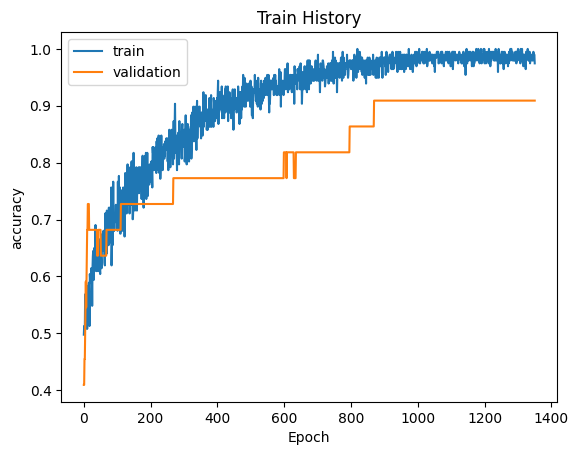

In [139]:
show_train_history(history ,'accuracy','val_accuracy')

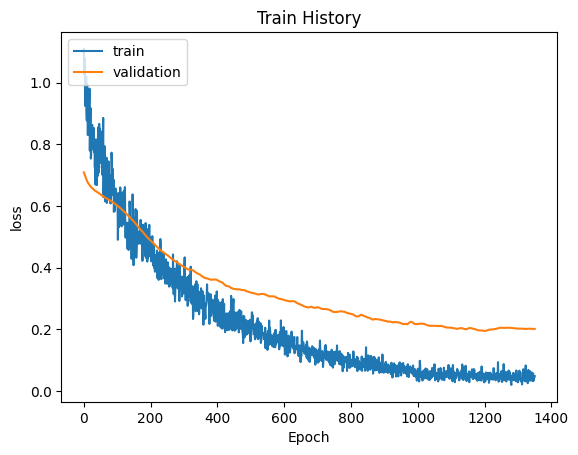

In [140]:
show_train_history(history ,'loss','val_loss')

In [146]:
metric_array(test_features, test_labels, history.model)

{'accuracy': 0.7547909407665505,
 'precision': 0.09180327868852459,
 'sensitivity': 0.8615384615384616,
 'specificity': 0.7516808606006276,
 'f1': 0.16592592592592592,
 'mcc': 0.23026535035886486}

In [143]:
# testing
metric_array(test_features, test_labels, history.model)

{'accuracy': 0.7547909407665505,
 'precision': 0.09180327868852459,
 'sensitivity': 0.8615384615384616,
 'specificity': 0.7516808606006276,
 'f1': 0.16592592592592592,
 'mcc': 0.23026535035886486}

In [145]:
len(test_features)

2296

In [147]:
history.model.save("ACVP_transfer.h5")